In [2]:
import pandas as pd
import numpy as np
import json
import glob
from pathlib import Path
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tslearn.metrics import cdist_dtw

# if you don’t already have it:
# pip install python-Levenshtein
from Levenshtein import distance as lev_distance


In [3]:
# Load all your JSON records
json_dir = "./data"
all_files = glob.glob(str(Path(json_dir) / "*.json"))

records = []
for fpath in all_files:
    with open(fpath, 'r') as f:
        try:
            data = json.load(f)
            if isinstance(data, list):
                records.extend(data)
            else:
                records.append(data)
        except json.JSONDecodeError:
            continue

df = pd.DataFrame(records)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"]).sort_values("timestamp")
df.set_index("timestamp", inplace=True)
df.head()

,type,collector_ip,peer_asn,prefix,as_path,origin,label
timestamp,,,,,,,
2004-12-23 09:20:03+00:00,withdrawal,192.65.185.144,6893,3,[2],None,0.0
2004-12-23 09:20:06+00:00,withdrawal,192.65.185.144,6893,2,[3],None,0.0
2004-12-23 09:20:12+00:00,announcement,192.65.185.142,20932,196.204.0.0/16,"[20932, 15412, 24835, 24835, 24835, 24835]",IGP,0.0
2004-12-23 09:20:12+00:00,announcement,192.65.185.142,20932,66.251.16.0/24,"[20932, 174, 13407, 32802]",IGP,0.0
2004-12-23 09:20:12+00:00,announcement,192.65.185.142,20932,202.179.152.0/24,"[20932, 3549, 3356, 15412]",IGP,0.0


In [4]:
feature_rows = []
labels = []

for window_start, group in df.groupby(pd.Grouper(freq="0.5Min")):
    if group.empty:
        continue

    # --- 1–2: counts of messages
    num_ann   = (group["type"] == "announcement").sum()
    num_wd    = (group["type"] == "withdrawal").sum()

    # --- 3–4: distinct NLRI prefixes announced/withdrawn
    num_ann_pref = group.loc[group["type"]=="announcement", "prefix"].nunique()
    num_wd_pref  = group.loc[group["type"]=="withdrawal",   "prefix"].nunique()

    # --- 5–7: AS‑PATH lengths
    # assume `as_path` is a list or space‑delimited string
    def to_list(x):
        if isinstance(x, list): return x
        return str(x).split()
    paths = group["as_path"].dropna().map(to_list)
    group = group.copy()
    group["as_path_tuple"] = paths.map(lambda p: tuple(p))

    path_lens = paths.map(len)

    avg_path_len       = path_lens.mean()  if not path_lens.empty else 0
    max_path_len       = path_lens.max()   if not path_lens.empty else 0
    avg_unique_path    = paths.map(lambda p: len(set(p))).mean() if not paths.empty else 0

    # --- 8–9: duplicates within window
    ann = group[group["type"]=="announcement"]
    wd  = group[group["type"]=="withdrawal"]

    num_dup_ann = ann.duplicated(subset=["prefix","as_path_tuple"]).sum()
    num_dup_wd  = wd.duplicated(subset=["prefix","as_path_tuple"]).sum()

    # --- 10: implicit withdrawals (if your JSON flags these)
    num_imp_wd = int(group.get("implicit_withdrawal", pd.Series()).sum()) \
                 if "implicit_withdrawal" in group else 0

    # --- 11–12: edit‑distance between consecutive AS‑PATHs
    edit_dists = []
    prev_path = None
    for path in paths:
        if prev_path is not None:
            # cast each AS to str before join
            s1 = " ".join(map(str, prev_path))
            s2 = " ".join(map(str, path))
            edit_dists.append(lev_distance(s1, s2))
        prev_path = path

    avg_edit = np.mean(edit_dists) if edit_dists else 0
    max_edit = np.max(edit_dists) if edit_dists else 0

    # --- 13: average inter‑arrival time (seconds)
    iat = group.index.to_series().diff().dt.total_seconds().dropna()
    avg_iat = iat.mean() if not iat.empty else 0

    # --- 14–24: binary flags for “is there any path of length == n?” for n=7..17
    as_bin = { f"as_len_eq_{n}": int((path_lens == n).any()) 
               for n in range(7,18) }

    # --- 25–33: binary flags “is max_path_len == n?” for n=7..15
    max_bin = { f"max_len_eq_{n}": int(max_path_len == n)
                for n in range(7,16) }

    # --- 34–36: protocol‑type packet counts (if your JSON has them)
    num_igp      = int(group["igp_packets"].sum())      if "igp_packets" in group else 0
    num_egp      = int(group["egp_packets"].sum())      if "egp_packets" in group else 0
    num_incompl  = int(group["incomplete_packets"].sum()) if "incomplete_packets" in group else 0

    # --- 37: average packet size
    avg_pkt_size = group["packet_size"].mean() if "packet_size" in group else 0

    # --- majority‐vote label in this window
    wl = group["label"].dropna().astype(int)
    label = 1 if (wl.sum()/len(wl) if len(wl)>0 else 0) > 0.5 else 0

    # collect everything
    row = {
        "num_ann": num_ann,
        "num_wd": num_wd,
        "num_ann_prefixes": num_ann_pref,
        "num_wd_prefixes": num_wd_pref,
        "avg_path_len": avg_path_len,
        "max_path_len": max_path_len,
        "avg_unique_path": avg_unique_path,
        "num_dup_ann": num_dup_ann,
        "num_dup_wd": num_dup_wd,
        "num_imp_wd": num_imp_wd,
        "avg_edit_dist": avg_edit,
        "max_edit_dist": max_edit,
        "avg_iat": avg_iat,
        **as_bin, **max_bin,
        "num_igp": num_igp,
        "num_egp": num_egp,
        "num_incomplete": num_incompl,
        "avg_packet_size": avg_pkt_size,
        "label": label
    }
    feature_rows.append(row)

features_df = pd.DataFrame(feature_rows).fillna(0)
features_df.index.name = "window_start"
features_df.head()

,num_ann,num_wd,num_ann_prefixes,num_wd_prefixes,avg_path_len,max_path_len,avg_unique_path,num_dup_ann,num_dup_wd,num_imp_wd,...,max_len_eq_11,max_len_eq_12,max_len_eq_13,max_len_eq_14,max_len_eq_15,num_igp,num_egp,num_incomplete,avg_packet_size,label
window_start,,,,,,,,,,,,,,,,,,,,,
0,43,2,33,2,4.866667,9,4.422222,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,140,0,125,0,5.250000,8,5.178571,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,218,2,142,2,5.113636,7,4.954545,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,105,0,98,0,4.961905,9,4.819048,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32,2,31,2,5.676471,13,4.705882,0,0,0,...,0,0,1,0,0,0,0,0,0,0


Classification Report:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        13
           1       0.00      0.00      0.00         6

    accuracy                           0.68        19
   macro avg       0.34      0.50      0.41        19
weighted avg       0.47      0.68      0.56        19

Confusion Matrix:
[[13  0]
 [ 6  0]]


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

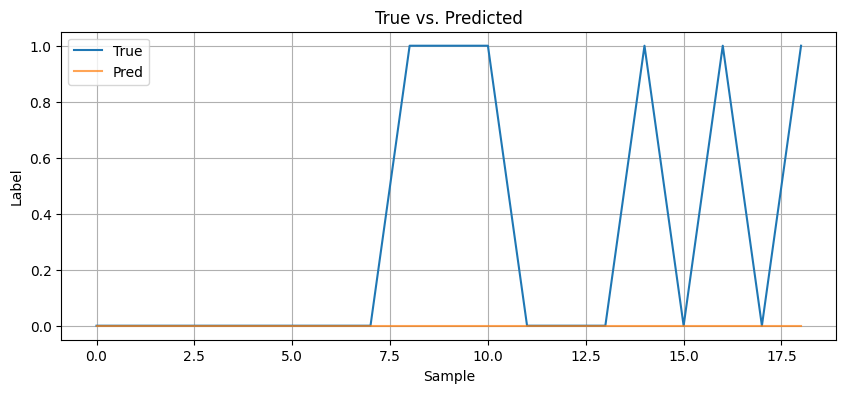

In [10]:
# --- Prepare your time series data ---

X = features_df.drop(columns="label").to_numpy()
y = features_df["label"].to_numpy()

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Compute pairwise DTW distances on training set ---
# dist_train = cdist_dtw(X_train)
dist_train = cdist_dtw(X_train, global_constraint="sakoe_chiba", sakoe_chiba_radius=3)

# --- Convert to DTW kernel (RBF-like similarity) ---
sigma = np.mean(dist_train)
kernel_train = np.exp(-dist_train**2 / (2 * sigma**2))

# --- Train SVM with precomputed kernel ---
clf = SVC(kernel="precomputed", C=1.0)
clf.fit(kernel_train, y_train)

# --- Compute DTW distances between test samples and training samples ---
dist_test = cdist_dtw(X_test, X_train)
kernel_test = np.exp(-dist_test**2 / (2 * sigma**2))

# --- Predict ---
y_pred = clf.predict(kernel_test)

# --- Evaluation ---
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- Plotting ---
plt.figure(figsize=(10,4))
plt.plot(y_test, label="True")
plt.plot(y_pred, alpha=0.7, label="Pred")
plt.legend()
plt.title("True vs. Predicted")
plt.xlabel("Sample")
plt.ylabel("Label")
plt.grid(True)
plt.show()


In [11]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from tslearn.metrics import cdist_dtw

# --- Parameters to search ---
C_values = [0.1, 1, 10]
sigma_values = [0.1, 1.0, 10.0]
sakoe_chiba_radius = 3  # Optional: constrain DTW warping window

# --- Preprocess ---
X = features_df.drop(columns="label").to_numpy()
y = features_df["label"].to_numpy()

# Normalize each time series individually
from sklearn.preprocessing import StandardScaler
X = np.array([StandardScaler().fit_transform(x.reshape(-1, 1)).flatten() for x in X])

# --- Cross-validation setup ---
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_score = -np.inf
best_params = {}

# --- Grid Search ---
for C in C_values:
    for sigma in sigma_values:
        scores = []

        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Compute DTW distance matrices
            dist_train = cdist_dtw(X_train, global_constraint="sakoe_chiba", sakoe_chiba_radius=sakoe_chiba_radius)
            dist_val = cdist_dtw(X_val, X_train, global_constraint="sakoe_chiba", sakoe_chiba_radius=sakoe_chiba_radius)

            # Convert to RBF-like kernel
            K_train = np.exp(-dist_train**2 / (2 * sigma**2))
            K_val = np.exp(-dist_val**2 / (2 * sigma**2))

            # Train SVM
            clf = SVC(kernel='precomputed', C=C)
            clf.fit(K_train, y_train)

            # Predict and score
            y_pred = clf.predict(K_val)
            f1 = f1_score(y_val, y_pred, average="macro")  # Use "binary" or "weighted" depending on your labels
            scores.append(f1)

        avg_score = np.mean(scores)
        print(f"C={C}, sigma={sigma} → Avg F1: {avg_score:.4f}")

        if avg_score > best_score:
            best_score = avg_score
            best_params = {"C": C, "sigma": sigma}

print("\nBest Parameters:")
print(best_params)
print(f"Best CV F1: {best_score:.4f}")


C=0.1, sigma=0.1 → Avg F1: 0.4013
C=0.1, sigma=1.0 → Avg F1: 0.4013
C=0.1, sigma=10.0 → Avg F1: 0.4013
C=1, sigma=0.1 → Avg F1: 0.4705
C=1, sigma=1.0 → Avg F1: 0.6324
C=1, sigma=10.0 → Avg F1: 0.4013
C=10, sigma=0.1 → Avg F1: 0.4973
C=10, sigma=1.0 → Avg F1: 0.6688
C=10, sigma=10.0 → Avg F1: 0.4622

Best Parameters:
{'C': 10, 'sigma': 1.0}
Best CV F1: 0.6688


In [12]:
# Use best C and sigma
C = best_params["C"]
sigma = best_params["sigma"]

# Split manually for final evaluation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Final training + test kernel
dist_train = cdist_dtw(X_train, global_constraint="sakoe_chiba", sakoe_chiba_radius=sakoe_chiba_radius)
dist_test = cdist_dtw(X_test, X_train, global_constraint="sakoe_chiba", sakoe_chiba_radius=sakoe_chiba_radius)
K_train = np.exp(-dist_train**2 / (2 * sigma**2))
K_test = np.exp(-dist_test**2 / (2 * sigma**2))

clf = SVC(kernel="precomputed", C=C)
clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.92      0.83        13
           1       0.67      0.33      0.44         6

    accuracy                           0.74        19
   macro avg       0.71      0.63      0.64        19
weighted avg       0.72      0.74      0.71        19

[[12  1]
 [ 4  2]]


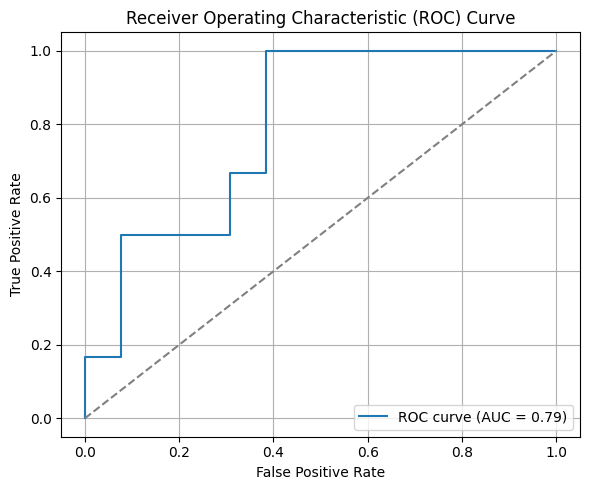

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get decision scores (continuous) instead of hard predictions
y_score = clf.decision_function(K_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
